<div class='bar_title'></div>

*Simulation for Decision Making (S4DM)*

# Assignment 6: Output Analysis (Single Model)

Summer Semester 24


Gunther Gust & Ignacio Ubeda <br>
Chair for Enterprise AI <br>
Data Driven Decisions Group <br>
Center for Artificial Intelligence and Data Science (CAIDAS)

<img src="images/d3.png" style="width:20%; float:left;" />

<img src="images/CAIDASlogo.png" style="width:20%; float:left;" />

# Agenda

* Model Validation
* Output Analysis (Single Model)

## Car wash example

In [462]:
import simpy
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
class EventLogger:
    def __init__(self):
        self.logs = []
        self.replication = None #replication number
        self.seed = None #seed used for the replication
    
    def set_replication_info(self, replication, seed):
        self.replication = replication
        self.seed = seed

    def log_car_arrival(self, entity, time):
        self.logs.append({'replication_id': self.replication, 'seed': self.seed, #replication info
                          'event_time': time, 'event_name': 'car_arrival', 'event_key': entity #simulation info
                          })
    
    def log_car_wash_request(self, entity, time):
        self.logs.append({'replication_id': self.replication, 'seed': self.seed, #replication info
                          'event_time': time, 'event_name': 'car_wash_request', 'event_key': entity #simulation info
                          })

    def log_car_departure(self, entity, time):
        self.logs.append({'replication_id': self.replication, 'seed': self.seed, #replication info
                          'event_time': time, 'event_name': 'car_departure', 'event_key': entity #simulation info
                          })

    def get_logs_df(self):
        return pd.DataFrame(self.logs)
    
    def dump_logs_df(self, filepath=None):
        if filepath is None: 
            filepath = "logs.csv"

        self.get_logs_df().to_csv(filepath, index=False)

In [56]:
class Carwash:
    def __init__(self, env, num_machines, logger):
        self.env = env
        self.machine = simpy.Resource(env, num_machines)
        self.logger = logger

    def wash(self):
        yield self.env.timeout(np.random.exponential(1/0.3))

In [7]:
class Car:
    def __init__(self, env, name, carwash, logger):
        self.env = env
        self.name = name
        self.logger = logger

        self.env.process(self.run(carwash))

    def run(self, carwash):
        
        # Log the arrival
        self.logger.log_car_arrival(self.name, self.env.now)
        with carwash.machine.request() as request:
            yield request

            # Log the request for car wash
            self.logger.log_car_wash_request(self.name, self.env.now)
            yield self.env.process(carwash.wash())

            #Log the departure
            self.logger.log_car_departure(self.name, self.env.now)

In [5]:
def car_generator(env, carwash, logger):
    car_count = 0

    # Create cars while the simulation is running
    while True:
        yield env.timeout(np.random.exponential(1/0.5))
        Car(env, f'Car {car_count}', carwash, logger)
        car_count += 1

## Run Simulation (now, for multiple replications)

In [355]:
# parameters
NUM_MACHINES = 2    # Number of machines in the carwash
SIM_TIME = 8*60       # Simulation time in minutes
N_REPLICATIONS = 20 # Number of Replications

# Setup and start the simulation
print('Running Simulation...')

#define logger (same for all replications)
logger = EventLogger()

#Compute a pool of seeds that is larger than the number of replications
safe_factor = 10
pool_of_seeds = range(1, N_REPLICATIONS * safe_factor)

#get a list of seeds of length: N_REPLICATIONS from a pool of seeds. 
#We set replace=False to ensure that we don't reuse the same seed twice.
list_of_seeds = np.random.choice(pool_of_seeds, size=N_REPLICATIONS, replace=False)

for i, seed in enumerate(list_of_seeds):
    print(f'Running Replication {i} with seed: {seed} ...')

    #set random seed
    np.random.seed(seed)

    #set replication id and random seed
    logger.set_replication_info(i, seed)

    # Create an environment and start the setup process
    env = simpy.Environment()

    #define resources
    carwash = Carwash(env, NUM_MACHINES, logger)

    #define processes
    env.process(car_generator(env, carwash, logger))

    # Execute
    env.run(until=SIM_TIME)

print('... Done')

Running Simulation...
Running Replication 0 with seed: 26 ...
Running Replication 1 with seed: 69 ...
Running Replication 2 with seed: 62 ...
Running Replication 3 with seed: 128 ...
Running Replication 4 with seed: 27 ...
Running Replication 5 with seed: 3 ...
Running Replication 6 with seed: 172 ...
Running Replication 7 with seed: 97 ...
Running Replication 8 with seed: 31 ...
Running Replication 9 with seed: 5 ...
Running Replication 10 with seed: 80 ...
Running Replication 11 with seed: 171 ...
Running Replication 12 with seed: 186 ...
Running Replication 13 with seed: 28 ...
Running Replication 14 with seed: 199 ...
Running Replication 15 with seed: 16 ...
Running Replication 16 with seed: 197 ...
Running Replication 17 with seed: 135 ...
Running Replication 18 with seed: 48 ...
Running Replication 19 with seed: 59 ...
... Done


In [356]:
events_df = logger.get_logs_df()

events_df

,replication_id,seed,event_time,event_name,event_key
0,0,26,0.736151,car_arrival,Car 0
1,0,26,0.736151,car_wash_request,Car 0
2,0,26,2.201555,car_arrival,Car 1
3,0,26,2.201555,car_wash_request,Car 1
4,0,26,5.315443,car_arrival,Car 2
...,...,...,...,...,...
14011,19,59,478.617340,car_wash_request,Car 243
14012,19,59,479.252076,car_departure,Car 240
14013,19,59,479.252076,car_wash_request,Car 244
14014,19,59,479.317408,car_departure,Car 244


# Exercise / Tasks

**Tasks are independently of each other.**

## Task 1: Model Validation

We'd like to validate our model. We've measured the actual average waiting time (2.8 mins) and would like to compare it with the output of our simulation model. 

-----

**Task 1.1: Create a dataframe `results_df` that contains the waiting time for every entity (car) for every replication. Recall that the waiting time is the timespan between the "*car_wash_request*" and "*car_arrival*" event. For computing this you can choose whatever approach you want. Check Hint 1 for a suggestion.**

**Task 1.2: Once you have `results_df`, compute the average waiting time for every replication. For computing this you can choose whatever approach you want. Check Hint 2 for a suggestion.**

After Task 1.2 you should have a table that looks like this (not same values, but structure):

<img src="images/assignment6_validation_lecture.png" style="width:30%" />

Where you have an aggregated metric for every replication (in the lecture example, $Y_2$). In our case, the table should have (at least) 2 columns: a replication id and the average waiting time for that replication.

**Task 1.3: Compute a confidence interval for the average waiting time (accross replications). Use the following formula (Lecture 8, slide 30):**

<img src="images/assignment6_ciformula_lecture.png" style="width:20%" />

**For gettint the t value, you may want to use `stats.t.ppf` from `scipy`. Check the [reference](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html) for more details.**

**Task 1.4: You've measure the actual average wating time (2.8 mins). Create an hypothesis test, interpret it, and check if your model is valid. For computing this you can choose whatever approach you want. Check Hint 3 for a suggestion.**

-----

**Hint 1:** `events_df` is in [long format](https://www.statology.org/long-vs-wide-data/). To compute the waiting time would be easier if its wide. To reshape from long to wide you could use the function: [`pd.pivot_table`](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html)

**Hint 2:** For aggregating a value (column `v`) with a function `f`  for every group (column `g`) of a DataFrame `df`. You can use the following syntax: `df.groupby('g').agg({'v': [f]})`. Check the [reference](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.aggregate.html) for more details.

**Hint 3:** `scipy` has a working implementation of a t-test: `stats.ttest_1samp`. Check the [reference](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html) for more details.


In [368]:
#pivot event name to columns, while keeping the replication_id, seed and event_key as index
results_df = pd.pivot_table(events_df, values='event_time', index=['replication_id', 'seed', 'event_key'], columns=['event_name'], aggfunc="sum")\
                .reset_index(drop=False)

#compute waiting time
results_df['waiting_time'] = results_df['car_wash_request'] - results_df['car_arrival']

print(results_df.columns)

results_df

Index(['replication_id', 'seed', 'event_key', 'car_arrival', 'car_departure',
       'car_wash_request', 'waiting_time'],
      dtype='object', name='event_name')


event_name,replication_id,seed,event_key,car_arrival,car_departure,car_wash_request,waiting_time
0,0,26,Car 0,0.736151,5.610490,0.736151,0.000000
1,0,26,Car 1,2.201555,9.016734,2.201555,0.000000
2,0,26,Car 10,18.560625,21.276846,20.766410,2.205785
3,0,26,Car 100,223.585451,226.254729,223.585451,0.000000
4,0,26,Car 101,225.035239,225.659417,225.035239,0.000000
...,...,...,...,...,...,...,...
4718,19,59,Car 95,209.242405,212.055971,209.242405,0.000000
4719,19,59,Car 96,210.829360,211.086953,210.829360,0.000000
4720,19,59,Car 97,213.763868,221.546437,213.763868,0.000000
4721,19,59,Car 98,214.284938,214.985040,214.284938,0.000000


In [369]:
#If you have followed Hint 1: Leave this code unchanged. If not, you can remove it.

#Note the "\"" character is used to split a long line of code into multiple lines
#We can therefore "chain" multiple operations together, which makes the code more readable

#1st: filter for replication 0
#2nd: sort by car arrival time (ascending)
#3rd: show the first 10 rows

results_df\
    .loc[results_df['replication_id'] == 0]\
    .sort_values(by='car_arrival', ascending=True)\
    .head(10)

event_name,replication_id,seed,event_key,car_arrival,car_departure,car_wash_request,waiting_time
0,0,26,Car 0,0.736151,5.610490,0.736151,0.000000
1,0,26,Car 1,2.201555,9.016734,2.201555,0.000000
112,0,26,Car 2,5.315443,6.657267,5.610490,0.295047
151,0,26,Car 3,5.731759,11.136272,6.657267,0.925508
162,0,26,Car 4,7.102880,10.124576,9.016734,1.913855
173,0,26,Car 5,7.536586,11.172210,10.124576,2.587990
184,0,26,Car 6,7.932867,12.294471,11.136272,3.203405
195,0,26,Car 7,9.480828,22.108536,11.172210,1.691382
206,0,26,Car 8,12.342908,15.142023,12.342908,0.000000
217,0,26,Car 9,17.231536,20.766410,17.231536,0.000000


In [370]:
within_replication_stats_df = results_df\
    .groupby('replication_id')\
    .agg({'waiting_time': ['mean', 'std']})\
    .reset_index(drop=False)

print(within_replication_stats_df.columns)
within_replication_stats_df

MultiIndex([('replication_id',     ''),
            (  'waiting_time', 'mean'),
            (  'waiting_time',  'std')],
           names=['event_name', None])


event_name replication_id waiting_time           
                                  mean        std
0                       0     5.235474   7.006840
1                       1     3.892310   5.217183
2                       2     2.426442   3.298117
3                       3     4.438091   4.270310
4                       4     3.651125   3.986137
5                       5     1.727736   2.539697
6                       6     4.808433   4.661344
7                       7     2.483037   3.883120
8                       8     2.622264   3.151187
9                       9     5.176021   6.618482
10                     10     6.537664   6.990595
11                     11     6.428733   8.196780
12                     12    10.494489  10.641762
13                     13     5.516319   5.562750
14                     14     3.804323   4.033078
15                     15    20.823272  16.174930
16                     16     6.741979   8.287379
17                     17     7.133312   6.268033
18                     18     3.796600   4.347322
19                     19     5.425357   5.197176

In [373]:
#significance level
alpha = 0.05

#compute mean, std and sample size
sample_size = N_REPLICATIONS
sample_mean = within_replication_stats_df['waiting_time']['mean'].mean()
sample_std = within_replication_stats_df['waiting_time']['mean'].std()

print(f"sample mean: {sample_mean}")
print(f"sample std: {sample_std}")

#Calculate t confidence interval

# Calculate the t-value for a 95% confidence interval (two-sided)
t_value = stats.t.ppf(1-alpha/2, sample_size - 1) 

# Calculate the half-width of the confidence interval
ci_halfwidth = t_value * sample_std / np.sqrt(sample_size)

#calculate the lower and upper bounds of the confidence interval
ci_lb = sample_mean - ci_halfwidth
ci_ub = sample_mean + ci_halfwidth

print(f"t confidence int: [{ci_lb}, {ci_ub}]") 

sample mean: 5.658149011997067
sample std: 4.10406501891316
t confidence int: [3.73738745826171, 7.578910565732425]


In [379]:
mu = 2.8

#perform  t-test (with scipy)
t_stat, p_value = stats.ttest_1samp(within_replication_stats_df['waiting_time']['mean'], mu)
print(t_stat, p_value)

#interpret the test
if p_value < alpha:
    print("Reject the null hypothesis; there is a significant difference between the sample mean and the actual measure => Needs to improve the model")
else:
    print("Fail to reject the null hypothesis; there is no significant difference between the sample mean and the actual measure => No reason to consider the model invalid")

3.114480619189496 0.005707805745589747
Reject the null hypothesis; there is a significant difference between the sample mean and the actual measure => Needs to improve the model


In [378]:
#perform  t-test ("manually")
t_statistic = np.abs((sample_mean-mu)/(sample_std/np.sqrt(sample_size)))

#interpret the test
if t_statistic > t_value:
    print("Reject the null hypothesis; there is a significant difference between the sample mean and the actual measure => Needs to improve the model")
else:
    print("Fail to reject the null hypothesis; there is no significant difference between the sample mean and the actual measure => No reason to consider the model invalid")


Reject the null hypothesis; there is a significant difference between the sample mean and the actual measure => Needs to improve the model


Answer the following questions:

- Is the simulation model valid?

**Answer in this markdown chunk:**

- *Your answer here* (**Answer:** No. Given the result of the t-test. There is a significant difference between the simulation and the actual measure and therefore we need to improve the model)

## Task 2: Number of Replications

We have run 100 replications of our simulation model and now we'd like to compute how many replications do we need to ensure a specific margin of error in our output measurement.

-----

**Task 2.1: With the available DataFrame (`replication_results`) compute the number of replications (R) needed to have an error $\epsilon = 0.2$ with a significance level $\alpha = 0.05.$ Use the following formula (Lecture 9, slide 27):**

<img src="images/assignment6_nreplications_lecture.png" style="width:20%" />

**For gettint the t value, you may want to use `stats.t.ppf` from `scipy`. Check the [reference](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html) for more details.**

**Task 2.2: Pack your implementation in a function `sample_size_calculator` and use it to answer how the sample size changes varying $\epsilon$ and $\alpha$**


In [380]:
replication_results = pd.read_csv('replication_results.csv')

print(replication_results.shape)
replication_results

(100, 3)


,replication_id,waiting_time_mean,waiting_time_std
0,0,7.842279,10.018218
1,1,7.670608,6.161879
2,2,4.256571,4.249491
3,3,3.166975,3.476930
4,4,5.662862,7.583478
...,...,...,...
95,95,3.796600,4.347322
96,96,3.517178,3.785145
97,97,4.175672,5.383726
98,98,15.229439,9.320103


In [565]:
epsilon = 0.2
alpha = 0.05

R0 = replication_results['replication_id'].nunique()
t_value = stats.t.ppf(1-alpha/2, R0 - 1)
s0 = replication_results['waiting_time_mean'].std()

R = round((t_value*s0/epsilon)**2)

R

1765

Answer the following questions:

- How many replications are needed?

**Answer in this markdown chunk:**

- *Your answer here* (**Answer:** 1765)

In [382]:
def sample_size_calculator(alpha, epsilon, s0, R0):
    t_value = stats.t.ppf(1-alpha/2, R0 - 1)
    R = round((t_value*s0/epsilon)**2)
    return R

In [383]:
#Leave this code unchanged

#define epsilon and alpha ranges
epsilon_values = np.arange(0.0, 1.0, 0.05)
alpha_values = np.arange(0.0, 1.0, 0.05)

data = []

#iterate over epsilon and alpha values
for epsilon in epsilon_values:
    for alpha in alpha_values:
        
        #compute sample size
        try:
            R = sample_size_calculator(alpha, epsilon, s0, R0)
        except OverflowError:
            R = np.nan

        #append results to data
        data.append({'alpha': round(alpha, 2), 'epsilon': round(epsilon, 2), 'sample_size': R})
        
#convert data to DataFrame and pivot
df = pd.DataFrame(data)
df = df.pivot(index="alpha", columns="epsilon", values="sample_size")

df

/var/folders/td/mhppvrk10nj_1j1gl_dk2pvc0000gn/T/ipykernel_64357/1278756766.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  R = round((t_value*s0/epsilon)**2)


epsilon,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
alpha,,,,,,,,,,,,,,,,,,,,
0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.05,NaN,28236.0,7059.0,3137.0,1765.0,1129.0,784.0,576.0,441.0,349.0,282.0,233.0,196.0,167.0,144.0,125.0,110.0,98.0,87.0,78.0
0.10,NaN,19772.0,4943.0,2197.0,1236.0,791.0,549.0,404.0,309.0,244.0,198.0,163.0,137.0,117.0,101.0,88.0,77.0,68.0,61.0,55.0
0.15,NaN,15095.0,3774.0,1677.0,943.0,604.0,419.0,308.0,236.0,186.0,151.0,125.0,105.0,89.0,77.0,67.0,59.0,52.0,47.0,42.0
0.20,NaN,11937.0,2984.0,1326.0,746.0,477.0,332.0,244.0,187.0,147.0,119.0,99.0,83.0,71.0,61.0,53.0,47.0,41.0,37.0,33.0
0.25,NaN,9603.0,2401.0,1067.0,600.0,384.0,267.0,196.0,150.0,119.0,96.0,79.0,67.0,57.0,49.0,43.0,38.0,33.0,30.0,27.0
0.30,NaN,7785.0,1946.0,865.0,487.0,311.0,216.0,159.0,122.0,96.0,78.0,64.0,54.0,46.0,40.0,35.0,30.0,27.0,24.0,22.0
0.35,NaN,6324.0,1581.0,703.0,395.0,253.0,176.0,129.0,99.0,78.0,63.0,52.0,44.0,37.0,32.0,28.0,25.0,22.0,20.0,18.0
0.40,NaN,5124.0,1281.0,569.0,320.0,205.0,142.0,105.0,80.0,63.0,51.0,42.0,36.0,30.0,26.0,23.0,20.0,18.0,16.0,14.0


<Axes: xlabel='epsilon', ylabel='alpha'>

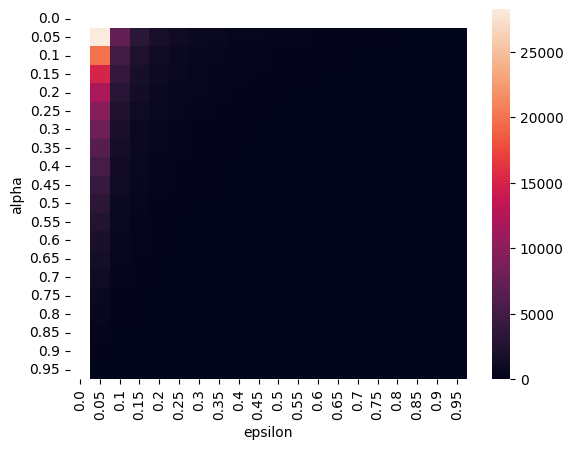

In [384]:
#Leave this code unchanged
sns.heatmap(df)

Answer the following questions:

1. How does the number of replications (R) change when changing $\epsilon$?
1. How does the number of replications (R) change when changing $\alpha$?

**Answer in this markdown chunk:**

1. *Your answer here* (**Answer:** More samples are needed when decreasing the margin of error)
1. *Your answer here* (**Answer:** More samples are needed when increasing (decreasing) the confidence (significance) level)

## Task 3: Quantile Confidence Interval

We'd like to compute a confidence interval for a a specific quantile of the average waiting time.

-----

**Task 3.1: Sort the the available DataFrame (`replication_results`) by the `waiting_time_mean` ascending. Create a `rank` column to get the position of the rows of the sorted DataFrame.**

**Task 3.2: Compute the quantile (lower and upper) bounds for the quantile $p=0.8$ with a significance level $\alpha = 0.05$. Use the following formula (Lecture 9, slide 29):**

<img src="images/assignment6_quantilebounds_lecture.png" style="width:20%" />

**For gettint the z value, you may want to use `stats.norm.ppf` from `scipy`. Check the [reference](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) for more details.**

**Task 3.3: Compute the point estimate and the bounds of the confidence interval with the indexes of the sorted DataFrame (i.e. the `rank` column). Check the example on Lecture 9, slide 30.**

**Task 3.4: Finally, we'll use a another approach using the `.quantile()` function. Check the [reference](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html) for more details and compare it with the result of Task 3.3**

In [389]:
#read csv
replication_results = pd.read_csv('replication_results.csv')
print(replication_results.shape)

#show the first 5 rows
replication_results.head()

(100, 3)


,replication_id,waiting_time_mean,waiting_time_std
0,0,7.842279,10.018218
1,1,7.670608,6.161879
2,2,4.256571,4.249491
3,3,3.166975,3.476930
4,4,5.662862,7.583478


In [390]:
#show last 5 rows
replication_results.tail()

,replication_id,waiting_time_mean,waiting_time_std
95,95,3.796600,4.347322
96,96,3.517178,3.785145
97,97,4.175672,5.383726
98,98,15.229439,9.320103
99,99,2.914842,3.821342


<Axes: xlabel='waiting_time_mean', ylabel='Count'>

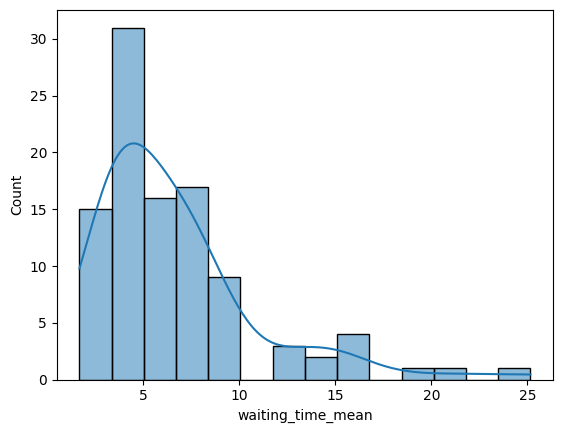

In [391]:
#plot histogram
sns.histplot(replication_results['waiting_time_mean'], kde=True)

In [392]:
#sort by waiting time mean (ascending)
replication_results = replication_results.sort_values(by='waiting_time_mean', ascending=True)

#create rank column
replication_results['rank'] = np.arange(1, replication_results.shape[0]+1)

replication_results

,replication_id,waiting_time_mean,waiting_time_std,rank
80,80,1.669962,2.429817,1
68,68,1.885828,2.499441,2
39,39,2.034499,2.744930,3
36,36,2.294612,3.588617,4
46,46,2.436914,3.393617,5
...,...,...,...,...
88,88,15.541900,14.287518,96
70,70,15.901701,11.878984,97
92,92,18.506948,17.583134,98
74,74,21.638821,11.734194,99


In [393]:
alpha = 0.05
quantile = 0.8
sample_size = replication_results.shape[0]

#compute z-value
z_value = stats.norm.ppf(1-alpha/2)

#compute quantile lower and upper bounds
quantile_lb = quantile - z_value * np.sqrt(quantile*(1-quantile)/(sample_size - 1))
quantile_ub = quantile + z_value * np.sqrt(quantile*(1-quantile)/(sample_size - 1))

print(quantile_lb, quantile_ub)

0.721206483159645 0.8787935168403551


In [394]:
#compute the row index of the quantile (lb, ub, and center)
quantile_lb_index = int(quantile_lb * sample_size)
quantile_index = int(quantile * sample_size)
quantile_ub_index = int(quantile_ub * sample_size)

#compute the point estimate
point_estimate = replication_results.loc[replication_results['rank'] == quantile_index]['waiting_time_mean'].values[0]

#compute the confidence interval
ci_lb = replication_results.loc[replication_results['rank'] == quantile_lb_index]['waiting_time_mean'].values[0]
ci_ub = replication_results.loc[replication_results['rank'] == quantile_ub_index]['waiting_time_mean'].values[0]

print(f"The point estimate is: {point_estimate}")
print(f"The {100*(1-alpha)}% CI is [{ci_lb}, {ci_ub}]")

The point estimate is: 8.417400768887848
The 95.0% CI is [7.663376828959767, 10.010619991719436]


In [395]:
#compute the point estimate (now with the quantile function)
point_estimate_quantfunc = replication_results['waiting_time_mean'].quantile(quantile)

#compute the confidence interval (now with the quantile function)
ci_lb_quantfunc = replication_results['waiting_time_mean'].quantile(quantile_lb)
ci_ub_quantfunc = replication_results['waiting_time_mean'].quantile(quantile_ub)

print(f"The point estimate (quantile function) is: {point_estimate_quantfunc}")
print(f"The {100*(1-alpha)}% CI (quantile function) is [{ci_lb_quantfunc}, {ci_ub_quantfunc}]")

The point estimate (quantile function) is: 8.42679887370355
The 95.0% CI (quantile function) is [7.666265221508928, 10.03461881928623]


Answer the following questions:

- What is the difference in values of both approaches? which one is better to use in which scenario?

**Answer in this markdown chunk:**

- *Your answer here* (**Answer:** The difference is only 0.009 in the point estimate (so in this case, in the thousandths). The "manual" approach incurs a rounding error (by forcing the indices to be integer values), but ensures the selected values will always be present in the "raw" dataset. The quantile approach is closer to the theoretical quantiles but there is no guarantee the returned values will be present in the data. Overall the quantile approach is easier to implement.)


## Task 4: Replication Method

Assuming now that our carwash runs 24/7, we're interested in implementing the replication method and differentiating between the transient vs the steady-state phase. 

For this task we'll change the metric to the queue length and we'll monitor it periodically to ensure we have exactly the same sampling frequency among different replications.

-----

**Task 4.1: Create a new method in the `EventLogger_Task4` to log the queue length. You should log (at least) the replication id, the time and the value of the queue length.**

**Task 4.2: Create a new process in the `Carwash_Task4` to monitor the queue length every 5 minutes. Note that this is a "ficticious" process that does not interact with the entity. The solely purpose is to monitor (and log) our variable of interest (queue length in this case).**

**Task 4.3: With this new changes, run your simulation replications (we provide this code for you) and filter the `events_t4_df` to get only the events related to the queue length.**

**Task 4.4: Plot the queue length over time. Note that since we have multiple records for the same time step (because we have one for each replication). The plot will aggregate the `y` value with a confidence interval around the mean.**

**Task 4.5: Determine a `T1` (the point in time where you should "cut" between transient and steady-state phase)**

**Task 4.6: Finally, compute the average queue length with and without the transient phase and compare your results. Note that you'll have to compute first the average queue length within replications and then, the average of this value accross replications.** 

In [406]:
class EventLogger_Task4:
    def __init__(self):
        self.logs = []
        self.replication = None #replication number
        self.seed = None #seed used for the replication
    
    def set_replication_info(self, replication, seed):
        self.replication = replication
        self.seed = seed

    def log_car_arrival(self, entity, time):
        self.logs.append({'replication_id': self.replication, 'seed': self.seed, #replication info
                          'event_time': time, 'event_name': 'car_arrival', 'event_key': entity #simulation info
                          })
    
    def log_car_wash_request(self, entity, time):
        self.logs.append({'replication_id': self.replication, 'seed': self.seed, #replication info
                          'event_time': time, 'event_name': 'car_wash_request', 'event_key': entity #simulation info
                          })

    def log_car_departure(self, entity, time):
        self.logs.append({'replication_id': self.replication, 'seed': self.seed, #replication info
                          'event_time': time, 'event_name': 'car_departure', 'event_key': entity #simulation info
                          })
        
    def log_queue_length(self, queue_length, time): #NEW
        self.logs.append({'replication_id': self.replication, 'seed': self.seed, #replication info
                          'event_time': time, 'event_name': 'queue_monitor', 'queue_length': queue_length #simulation info
                          })

    def get_logs_df(self):
        return pd.DataFrame(self.logs)
    
    def dump_logs_df(self, filepath=None):
        if filepath is None: 
            filepath = "logs.csv"

        self.get_logs_df().to_csv(filepath, index=False)

In [455]:
class Carwash_Task4:
    def __init__(self, env, num_machines, logger):
        self.env = env
        self.machine = simpy.Resource(env, num_machines)
        self.logger = logger

        self.env.process(self.monitor_queue_length()) #NEW - start the monitor process

    def wash(self):
        yield self.env.timeout(np.random.exponential(1/0.3))
    
    def monitor_queue_length(self): #fictitious method to monitor the queue length
        while True:
            self.logger.log_queue_length(len(self.machine.queue), self.env.now)
            yield self.env.timeout(5) #monitor every 5 minute

In [546]:
# parameters
NUM_MACHINES = 2       # Number of machines in the carwash
SIM_TIME = 7*24*60      # Simulation time in minutes
N_REPLICATIONS = 30     # Number of Replications

# Setup and start the simulation
print('Running Simulation...')

#define logger (same for all replications)
logger_t4 = EventLogger_Task4()

#Compute a pool of seeds that is larger than the number of replications
safe_factor = 10
pool_of_seeds = range(1, N_REPLICATIONS * safe_factor)

#get a list of seeds of length: N_REPLICATIONS from a pool of seeds. 
#We set replace=False to ensure that we don't reuse the same seed twice.
list_of_seeds = np.random.choice(pool_of_seeds, size=N_REPLICATIONS, replace=False)

for i, seed in enumerate(list_of_seeds):
    print(f'Running Replication {i} with seed: {seed} ...')

    #set random seed
    np.random.seed(seed)

    #set replication id and random seed
    logger_t4.set_replication_info(i, seed)

    # Create an environment and start the setup process
    env_t4 = simpy.Environment()

    #define resources
    carwash_t4 = Carwash_Task4(env_t4, NUM_MACHINES, logger_t4)

    #define processes
    #we use the same car_generator and Car class because has not changed
    env_t4.process(car_generator(env_t4, carwash_t4, logger_t4))

    # Execute
    env_t4.run(until=SIM_TIME)

print('... Done')

Running Simulation...
Running Replication 0 with seed: 201 ...
Running Replication 1 with seed: 61 ...
Running Replication 2 with seed: 3 ...
Running Replication 3 with seed: 219 ...
Running Replication 4 with seed: 218 ...
Running Replication 5 with seed: 208 ...
Running Replication 6 with seed: 126 ...
Running Replication 7 with seed: 159 ...
Running Replication 8 with seed: 231 ...
Running Replication 9 with seed: 47 ...
Running Replication 10 with seed: 235 ...
Running Replication 11 with seed: 240 ...
Running Replication 12 with seed: 195 ...
Running Replication 13 with seed: 24 ...
Running Replication 14 with seed: 175 ...
Running Replication 15 with seed: 233 ...
Running Replication 16 with seed: 76 ...
Running Replication 17 with seed: 10 ...
Running Replication 18 with seed: 206 ...
Running Replication 19 with seed: 258 ...
Running Replication 20 with seed: 178 ...
Running Replication 21 with seed: 234 ...
Running Replication 22 with seed: 32 ...
Running Replication 23 with se

In [547]:
events_t4_df = logger_t4.get_logs_df()

print(events_t4_df.shape)
events_t4_df.head(20)

(513425, 6)


,replication_id,seed,event_time,event_name,queue_length,event_key
0,0,201,0.000000,queue_monitor,0.0,NaN
1,0,201,0.241861,car_arrival,NaN,Car 0
2,0,201,0.241861,car_wash_request,NaN,Car 0
3,0,201,2.997568,car_arrival,NaN,Car 1
4,0,201,2.997568,car_wash_request,NaN,Car 1
5,0,201,3.389623,car_departure,NaN,Car 0
6,0,201,5.000000,queue_monitor,0.0,NaN
7,0,201,6.315789,car_arrival,NaN,Car 2
8,0,201,6.315789,car_wash_request,NaN,Car 2
9,0,201,6.617520,car_arrival,NaN,Car 3


In [553]:
#get only the queue_monitor events
queue_data = events_t4_df.loc[events_t4_df['event_name'] == 'queue_monitor']

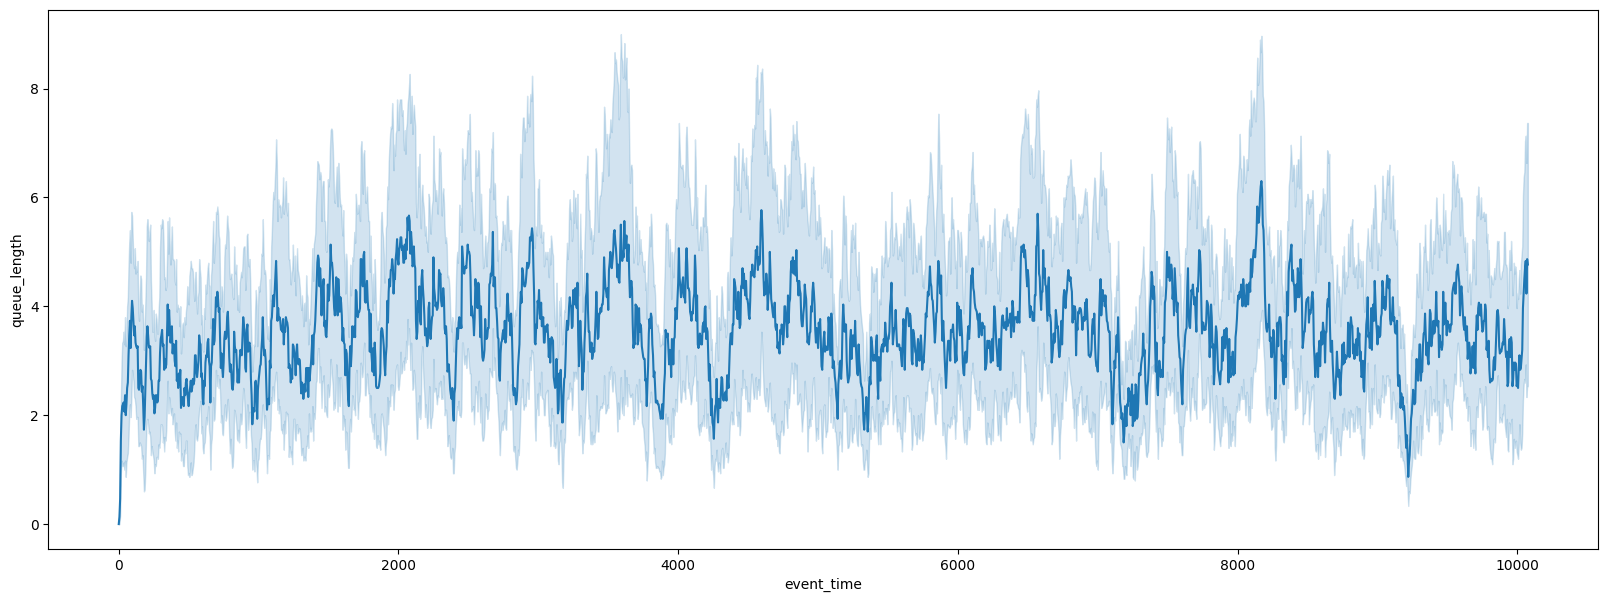

In [554]:
#set figure size
f, ax = plt.subplots(1, figsize=(20, 7))

#plot the queue length over time
sns.lineplot(data=queue_data, x='event_time', y='queue_length', ax=ax)
plt.show()

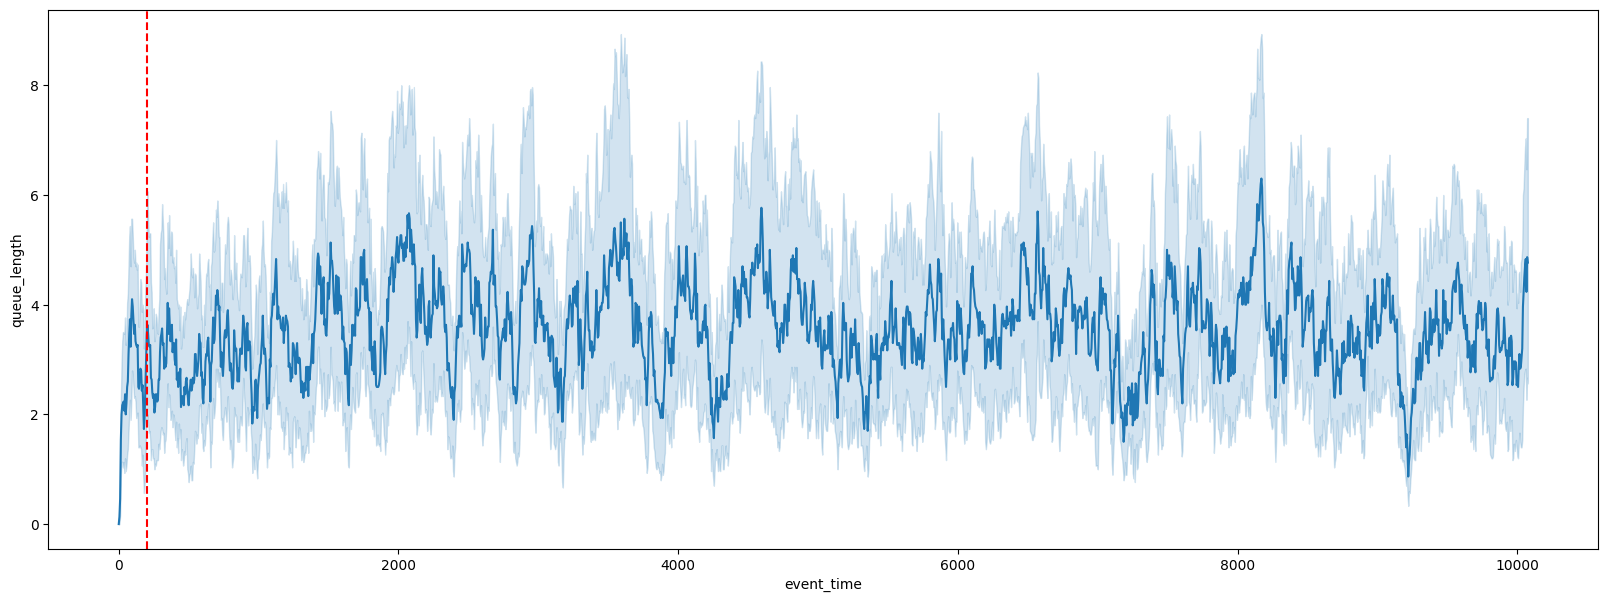

In [555]:
#Define the time point T1
T1 = 200

#set figure size
f, ax = plt.subplots(1, figsize=(20, 7))

#plot the queue length over time
sns.lineplot(data=queue_data, x='event_time', y='queue_length', ax=ax)
plt.axvline(x=T1, color='r', linestyle='--')
plt.show()

In [569]:
#Check rule of thumb: TE > 10*T1
TE = (SIM_TIME-T1)
print(TE > 10*T1)

True


In [570]:

#Compute the point estimate of the mean queue length accross all replications
avg_queue_df = queue_data\
    .groupby('replication_id')\
    .agg({'queue_length': 'mean'})\
    .reset_index(drop=False)

point_estimator_with_transient = avg_queue_df['queue_length'].mean()
point_estimator_with_transient

3.5421792328042323

In [571]:
#Compute the point estimate of the mean queue length accross all replications but deleting the first T1 minutes
avg_queue_df = queue_data\
    .loc[queue_data['event_time'] > T1]\
    .groupby('replication_id')\
    .agg({'queue_length': 'mean'})\
    .reset_index(drop=False)

point_estimator_without_transient = avg_queue_df['queue_length'].mean()
point_estimator_without_transient

3.5616877637130795

In [572]:
#Compare the point estimates
point_estimator_with_transient - point_estimator_without_transient

-0.019508530908847188

Answer the following questions:

- What is the difference in the point estimates?

**Answer in this markdown chunk:**

- *Your answer here* (**Answer:** 0.019. Considering the transient phase will underestimate the measure of interest)